In [1]:
import train_test
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
from model_conv import SimpleCNNSmall, SimpleCNNTiny

model = SimpleCNNSmall()

In [14]:
model.load_state_dict(
    torch.load(r"D:\Internship\bimsa\result\predictor_life_simple\2025-10-17_23-41-56_small_2_layer_seq_cnn__200-200-B3678_S34678\best_simple_life_SimpleCNNSmall_0.1.0.pth"
               , map_location=torch.device('cuda')
            ),
)

<All keys matched successfully>

In [15]:
import os

from typing import Iterable, Tuple
from jaxtyping import Float, Array

from dataloader import get_dataloader

from tqdm import tqdm

In [16]:

bimsa_life_100_dir = os.environ.get('BIMSA_LIFE_100_DIR', "../predictor_life/datasets/life/")

test_loader: Iterable[Tuple[Float[Array, "batch 2 w h"], Float[Array, "batch 2 w h"]]] = get_dataloader(
    data_dir=r"D:\Internship\bimsa\predictor_life_simple\datasets\200-200-B3678_S34678",
    batch_size=64,
    shuffle=True,
    num_workers=0,
    split='all'
)

In [ ]:
class CountingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.counting_kenel = torch.nn.Conv2d(1, 1, 3, 1, 1, padding_mode="circular", bias=False)
        
        with torch.no_grad():
            self.counting_kenel.weight.copy_(torch.tensor(
                [[[
                    [1,  1,  1],
                    [1,  0,  1],
                    [1,  1,  1]
                ]]],
                requires_grad=False
            ))
        
        for param in self.parameters():
            param.requires_grad_(False)
        
        print(self.counting_kenel.state_dict())
    
    def forward(self, x):
        return self.counting_kenel(x)

In [18]:
test_count = CountingCNN()

OrderedDict([('weight', tensor([[[[1., 1., 1.],
          [1., 0., 1.],
          [1., 1., 1.]]]]))])


In [19]:
from typing import List
from numba import jit

# @jit
def stat_fn(l: List[List[int]], d: List[List[int]]):
    for (i, c, o) in l:
        k = int(2*i + o)
        d[k].append(c)

In [20]:
from einops import rearrange

d = [[-1], [-1], [-1], [-1]]

for idx, (inputs, _) in tqdm(enumerate(test_loader)):

    outputs = model(inputs)
    
    in_state = inputs[:, 1:, :, :]
    counts = test_count(inputs)
    pred = outputs.argmax(dim=1)[:, None, ...]
    
    stat_arr = torch.stack([in_state, counts, pred], dim=0)
    stat_arr = list(rearrange(stat_arr, "n b c w h -> (b c w h) n").numpy())
    # print(stat_arr.shape)
    
    stat_fn(stat_arr, d)
    
    if idx == 10:
        break

10it [01:19,  7.97s/it]


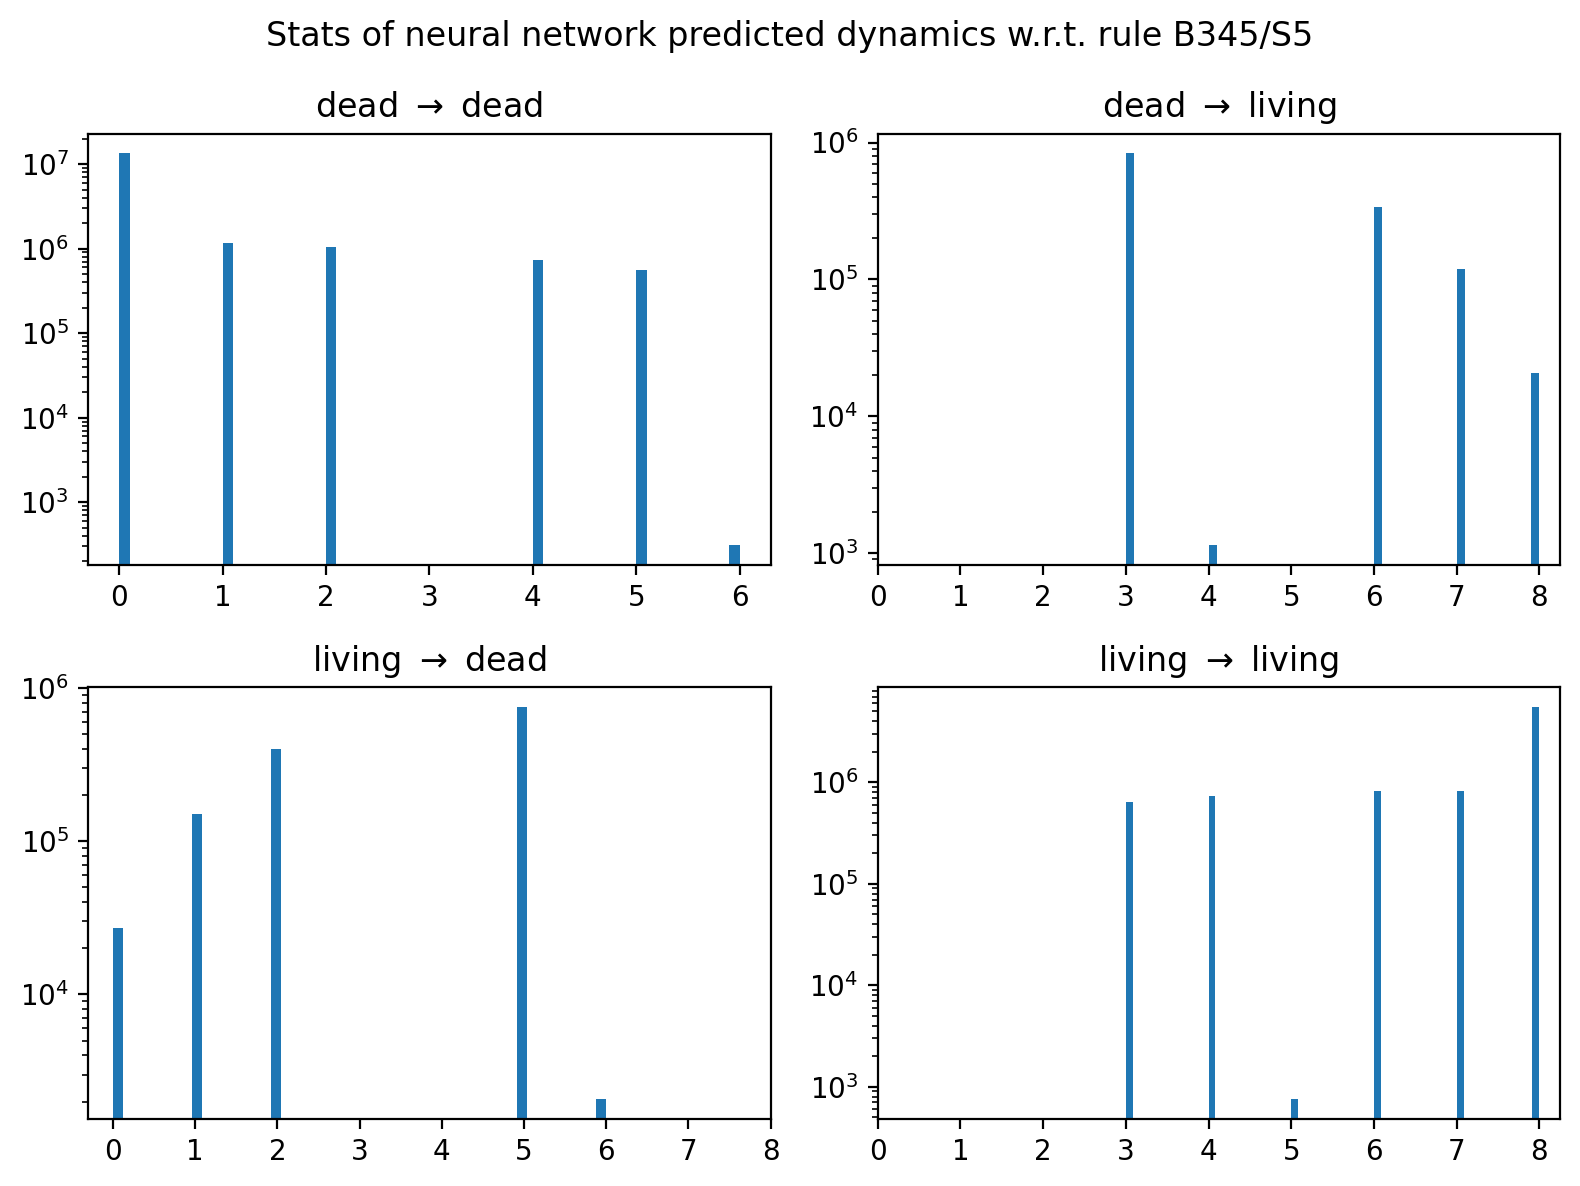

In [ ]:
import matplotlib.pyplot as plt

stat_ls = [i[1:] for i in d]

plt.figure(dpi=200, figsize=(8, 6))

plt.suptitle("Stats of neural network predicted dynamics w.r.t. rule B3678/S34678")

plt.subplot(2, 2, 1)
plt.hist(stat_ls[0], bins=len(set(stat_ls[0])) * 10)
plt.xticks(range(9), range(9))
plt.semilogy()
plt.title("dead $\\rightarrow$ dead")

plt.subplot(2, 2, 2)
plt.hist(stat_ls[1], bins=len(set(stat_ls[1])) * 10)
plt.semilogy()
plt.xticks(range(9), range(9))
plt.title("dead $\\rightarrow$ living")

plt.subplot(2, 2, 3)
plt.hist(stat_ls[2], bins=len(set(stat_ls[2])) * 10)
plt.semilogy()
plt.xticks(range(9), range(9))
plt.title("living $\\rightarrow$ dead")

plt.subplot(2, 2, 4)
plt.hist(stat_ls[3], bins=max(1, len(set(stat_ls[3]))) * 10)
plt.semilogy()
plt.xticks(range(9), range(9))
plt.title("living $\\rightarrow$ living")

plt.tight_layout()

In [22]:
from einops import rearrange

d = [[-1], [-1], [-1], [-1]]

for idx, (inputs, labels) in tqdm(enumerate(test_loader)):
    inputs, labels = inputs, labels
    
    in_state = inputs[:, 1:, ...]
    counts = test_count(inputs)
    pred = labels[:, None, ...]
    
    stat_arr = torch.stack([in_state, counts, pred], dim=0)
    stat_arr = list(rearrange(stat_arr, "n b c w h -> (b c w h) n").numpy())
    # print(stat_arr.shape)
    
    stat_fn(stat_arr, d)
    
    if idx == 10:
        break

10it [01:15,  7.54s/it]


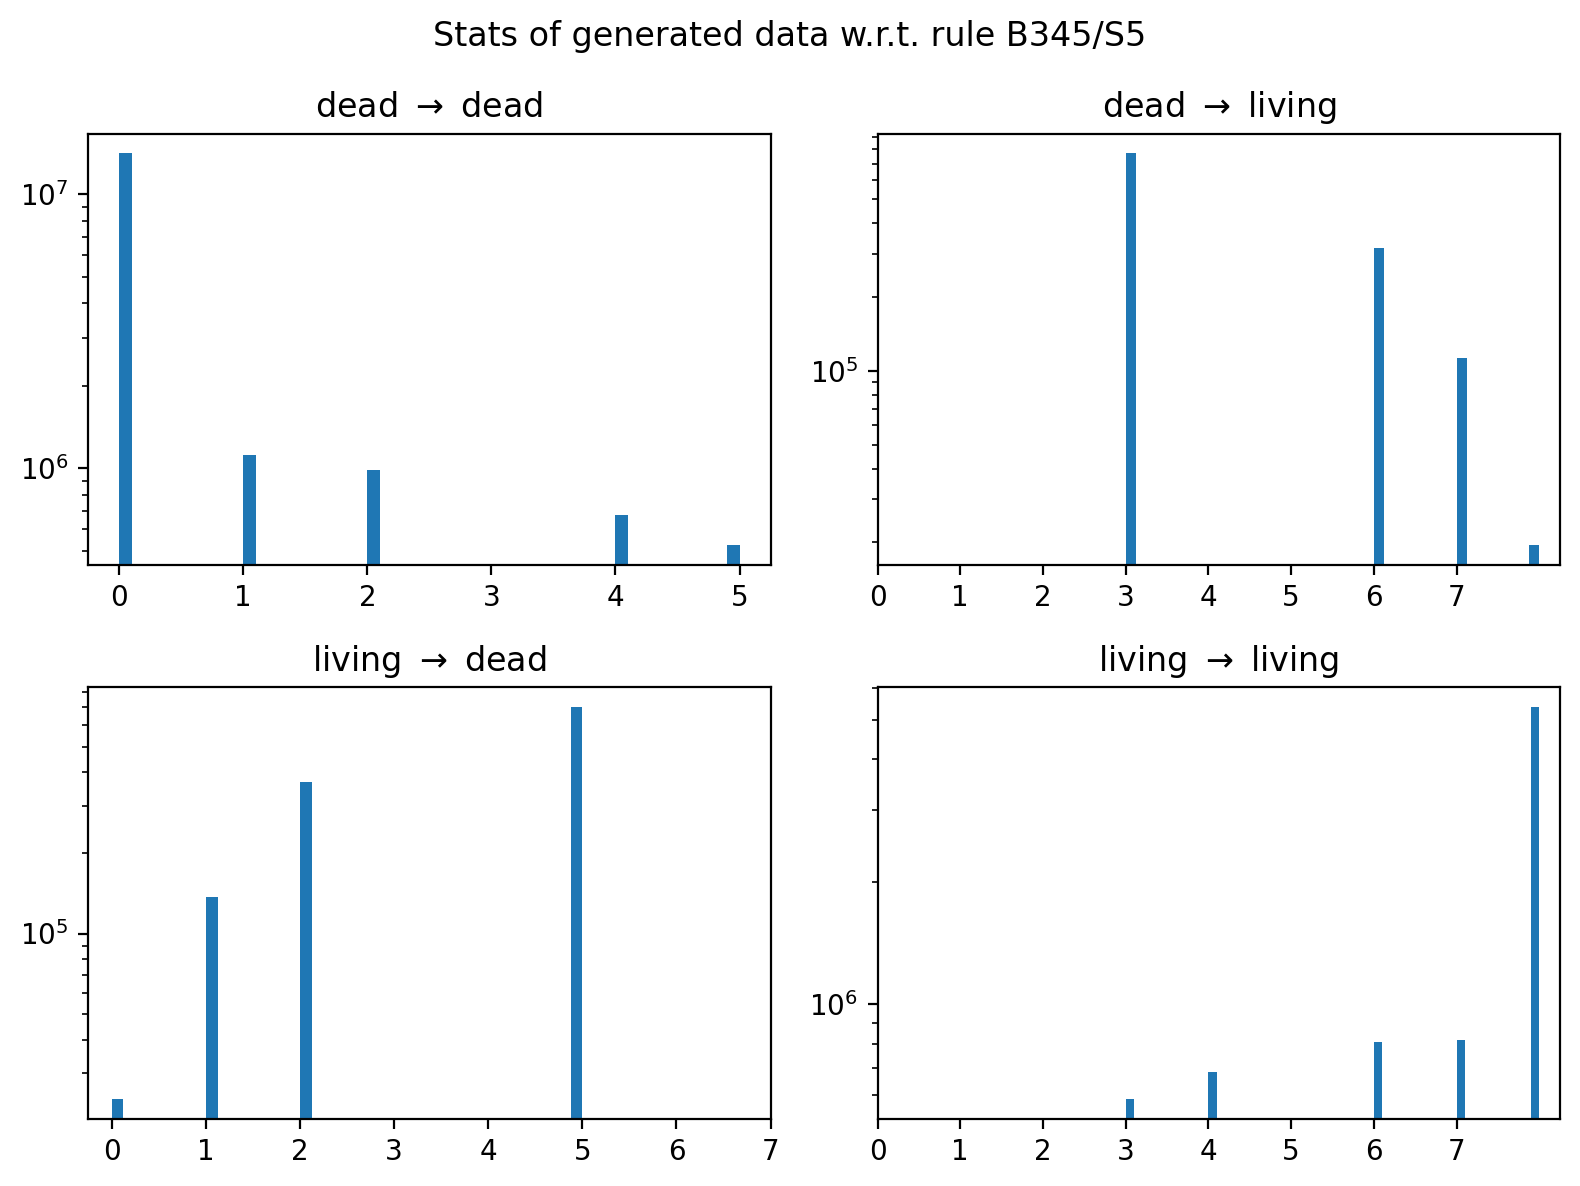

In [23]:
import matplotlib.pyplot as plt

stat_ls = [i[1:] for i in d]

plt.figure(dpi=200, figsize=(8, 6))

plt.suptitle("Stats of generated data w.r.t. rule B345/S5")

plt.subplot(2, 2, 1)
plt.hist(stat_ls[0], bins=len(set(stat_ls[0])) * 10)
plt.xticks(range(8), range(8))
plt.semilogy()
plt.title("dead $\\rightarrow$ dead")

plt.subplot(2, 2, 2)
plt.hist(stat_ls[1], bins=len(set(stat_ls[1])) * 10)
plt.semilogy()
plt.xticks(range(8), range(8))
plt.title("dead $\\rightarrow$ living")

plt.subplot(2, 2, 3)
plt.hist(stat_ls[2], bins=len(set(stat_ls[2])) * 10)
plt.semilogy()
plt.xticks(range(8), range(8))
plt.title("living $\\rightarrow$ dead")

plt.subplot(2, 2, 4)
plt.hist(stat_ls[3], bins=max(1, len(set(stat_ls[3]))) * 10)
plt.semilogy()
plt.xticks(range(8), range(8))
plt.title("living $\\rightarrow$ living")

plt.tight_layout()

---

In [7]:
from pprint import pprint

pprint(list(model.state_dict().keys()))

['conv1.weight',
 'conv1.bias',
 'bn1.weight',
 'bn1.bias',
 'bn1.running_mean',
 'bn1.running_var',
 'bn1.num_batches_tracked',
 'conv2.weight',
 'conv2.bias',
 'bn2.weight',
 'bn2.bias',
 'bn2.running_mean',
 'bn2.running_var',
 'bn2.num_batches_tracked',
 'conv3.weight',
 'conv3.bias']


In [ ]:
import numpy as np
np.printoptions(precision=2, formatter=".2f")

pprint(model.state_dict()["conv1.weight"].numpy())

array([[[[-4.99663875e-04,  1.49195902e-02,  2.62800828e-02],
         [ 3.41995806e-03, -1.93599328e-01,  1.94211677e-02],
         [ 6.63502701e-03,  2.01779865e-02,  1.19335875e-02]],

        [[-1.41301334e+00, -1.39460206e+00, -1.42714334e+00],
         [-1.37385738e+00, -1.47881866e+00, -1.37254047e+00],
         [-1.41375709e+00, -1.38936758e+00, -1.41632116e+00]]]],
      dtype=float32)


: 

In [10]:
pprint(model.state_dict()["conv1.bias"].numpy())

array([ 0.7097601, -1.0100366], dtype=float32)


array([[[[-1.96540102e-01, -3.60906410e+00, -7.05599412e-03],
         [ 3.62445414e-03,  1.81412566e+00,  1.81353122e-01],
         [-1.42534569e-01,  2.85983354e-01, -7.20049292e-02]],

        [[ 3.94148678e-01,  1.47002566e+00,  4.98173714e-01],
         [ 4.66447741e-01, -9.81643237e-03,  4.94958848e-01],
         [ 5.31325221e-01,  6.16252720e-01,  5.70353210e-01]]],


       [[[ 1.08793013e-01, -3.94710445e+00, -1.96521338e-02],
         [-7.22731650e-02, -1.14093316e+00, -2.52340078e-01],
         [ 1.74747333e-01, -2.85994172e-01,  1.07565254e-01]],

        [[-8.93028021e-01, -1.75982386e-01, -9.52308476e-01],
         [-6.66110337e-01, -8.57651591e-01, -7.43056536e-01],
         [-4.62188095e-01, -4.24644977e-01, -4.60742623e-01]]]],
      dtype=float32)


In [1]:
import numpy as np
import sympy as sp

In [3]:
matrix = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1/2, 0, 1/2, 0, 0, 0],
    [0, 0, 0, 1/2, 0, 1/2, 0, 0],
    [1/2, 1/2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1/2, 1/2],
    [0, 0, 1/2, 0, 1/2, 0, 0, 0],
    [0, 0, 0, 1/2, 0, 1/2, 0, 0],
    [0, 0, 0, 0, 0, 0, 1/2, 1/2]
])

In [9]:
A = sp.Matrix(
    [[1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1/2, 0, 1/2, 0, 0, 0],
    [0, 0, 0, 1/2, 0, 1/2, 0, 0],
    [1/2, 1/2, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1/2, 1/2],
    [0, 0, 1/2, 0, 1/2, 0, 0, 0],
    [0, 0, 0, 1/2, 0, 1/2, 0, 0],
    [0, 0, 0, 0, 0, 0, 1/2, 1/2]]
)

In [10]:
A

Matrix([
[  1,   0,   0,   0,   0,   0,   0,   0],
[  0,   0, 0.5,   0, 0.5,   0,   0,   0],
[  0,   0,   0, 0.5,   0, 0.5,   0,   0],
[0.5, 0.5,   0,   0,   0,   0,   0,   0],
[  0,   0,   0,   0,   0,   0, 0.5, 0.5],
[  0,   0, 0.5,   0, 0.5,   0,   0,   0],
[  0,   0,   0, 0.5,   0, 0.5,   0,   0],
[  0,   0,   0,   0,   0,   0, 0.5, 0.5]])

In [11]:
A**7

Matrix([
[        1,         0,         0,         0,         0,         0,         0,         0],
[0.3671875, 0.0546875, 0.0859375, 0.1015625, 0.0859375, 0.1015625, 0.1015625, 0.1015625],
[  0.46875,  0.046875, 0.0703125, 0.0859375, 0.0703125, 0.0859375, 0.0859375, 0.0859375],
[  0.65625,   0.03125,  0.046875, 0.0546875,  0.046875, 0.0546875, 0.0546875, 0.0546875],
[0.3671875, 0.0546875, 0.0859375, 0.1015625, 0.0859375, 0.1015625, 0.1015625, 0.1015625],
[0.3671875, 0.0546875, 0.0859375, 0.1015625, 0.0859375, 0.1015625, 0.1015625, 0.1015625],
[  0.46875,  0.046875, 0.0703125, 0.0859375, 0.0703125, 0.0859375, 0.0859375, 0.0859375],
[0.3671875, 0.0546875, 0.0859375, 0.1015625, 0.0859375, 0.1015625, 0.1015625, 0.1015625]])

In [12]:
A**8

Matrix([
[         1,          0,          0,          0,          0,          0,          0,          0],
[0.41796875, 0.05078125,   0.078125,    0.09375,   0.078125,    0.09375,    0.09375,    0.09375],
[0.51171875, 0.04296875, 0.06640625,   0.078125, 0.06640625,   0.078125,   0.078125,   0.078125],
[0.68359375, 0.02734375, 0.04296875, 0.05078125, 0.04296875, 0.05078125, 0.05078125, 0.05078125],
[0.41796875, 0.05078125,   0.078125,    0.09375,   0.078125,    0.09375,    0.09375,    0.09375],
[0.41796875, 0.05078125,   0.078125,    0.09375,   0.078125,    0.09375,    0.09375,    0.09375],
[0.51171875, 0.04296875, 0.06640625,   0.078125, 0.06640625,   0.078125,   0.078125,   0.078125],
[0.41796875, 0.05078125,   0.078125,    0.09375,   0.078125,    0.09375,    0.09375,    0.09375]])

In [13]:
x = sp.Matrix(
    [[1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8]]
)

In [20]:
x * A**5

Matrix([[0.41796875, 0.05078125, 0.078125, 0.09375, 0.078125, 0.09375, 0.09375, 0.09375]])

In [ ]:
0.41796875 * 256

107.0

: 